# Financial Engineering Project
### Reaz Yarmohamadi

In [131]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from math import exp, sqrt
from scipy.stats import norm

# Part 1

#### Part A

In [132]:
# Initialise parameters
S0 = 100      # initial stock price
K = 100       # strike price
T = 1         # time to maturity in years
r = 0.06      # annual risk-free rate
N = 3         # number of time steps
u = 1.1       # up-factor in binomial models
d = 1/u       # ensure recombining tree
opttype = 'C' # Option Type 'C' or 'P'

def bionomial_tree(K,T,S0,r,N,u,d,opttype):
    dt = T/N
    p = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)
    tree = pd.DataFrame(data={'Stock Prices':[0]*(N+1), 'Option Prices':[0]*(N+1), 'y-coordinates':[0]*(N+1)})
    tree = tree.astype('object')
    tree.iloc[0,0] = [S0]
    
    step = 1
    while step <= N:
        temp = []
        for i in tree.iloc[step-1,0]:
            temp.append(round(i*d, 2))
            temp.append(round(i*u, 2))
        tree.iloc[step, 0] = temp
        step += 1
    
    if opttype == 'C':
        tree.iloc[N,1] = [round(max(Xt-K, 0), 2) for Xt in tree.iloc[N,0]]
    elif opttype == 'P':
        tree.iloc[N,1] = [round(max(K-Xt, 0), 2) for Xt in tree.iloc[N,0]]
    
    for i in range(N-1, -1, -1):
        temp = []
        for j in range(0,2**(i+1),2):
            price = round(disc * ((1-p)*tree.iloc[i+1,1][j] + p*tree.iloc[i+1,1][j+1]), 2)
            temp.append(price)
        tree.iloc[i,1] = temp

    ### y-coordinates
    tree.iloc[N,2] = [round((0.4*y-2**(N-1)*0.4), 2) for y in range(2**N+1)]
    tree.iloc[N,2].remove(0)
    
    for i in range(N-1, -1, -1):
        temp = []
        tree.iloc[i,2] = [round((tree.iloc[i+1,2][2*x] + tree.iloc[i+1,2][2*x+1])/2, 2) for x in range(2**i)]

    return tree


### You can change parameters here
bi_tree = bionomial_tree(K,T,S0,r,N,u,d,opttype)
bi_tree

,Stock Prices,Option Prices,y-coordinates
0,[100],[10.15],[0.0]
1,"[90.91, 110.0]","[3.25, 15.45]","[-1.0, 1.0]"
2,"[82.65, 100.0, 100.0, 121.0]","[0.0, 5.7, 5.7, 22.98]","[-1.4, -0.6, 0.6, 1.4]"
3,"[75.14, 90.92, 90.91, 110.0, 90.91, 110.0, 110...","[0, 0, 0, 10.0, 0, 10.0, 10.0, 33.1]","[-1.6, -1.2, -0.8, -0.4, 0.4, 0.8, 1.2, 1.6]"


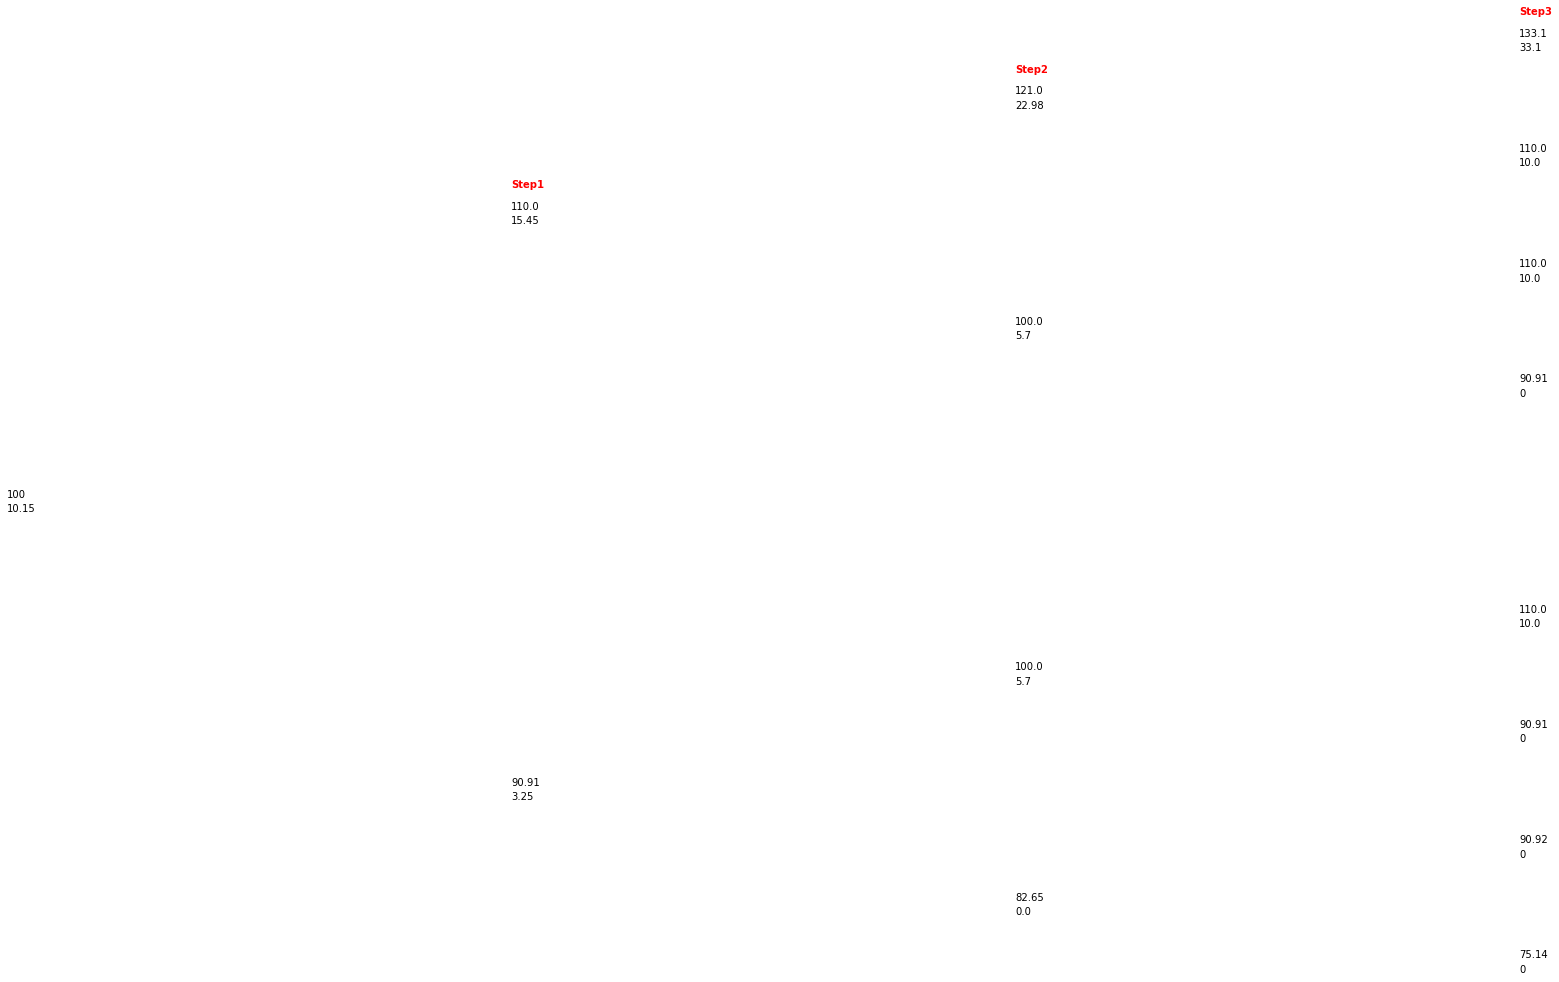

In [133]:
### Displaying Binomial Tree
### Don't pass more than 7 steps (not enough space)
dx = 3.5 / N
dy = 0.2
mini_dy = 0.025
counter = 0
plt.xlim(0, 4)
plt.ylim(-10, 10)
for index, row in bi_tree.iterrows():
    if counter == 0:
        plt.figtext(0,0+mini_dy,bi_tree.iloc[0,0][0]) ### S_0
        plt.figtext(0,0-mini_dy,bi_tree.iloc[0,1][0]) ### f_0
        counter += 1
        continue
    plt.figtext(counter*dx, row[2][2**counter-1]+4*mini_dy, "Step"+str(counter), fontdict={'fontweight': 1000, 'color': 'red'})
    for i in range(2**counter):
        plt.figtext(counter*dx, row[2][i]+mini_dy, bi_tree.iloc[counter,0][i]) ### Stock Price
        plt.figtext(counter*dx, row[2][i]-mini_dy, bi_tree.iloc[counter,1][i]) ### Option Price
    counter += 1

plt.axis('off')
plt.show()

#### Part B

I used DerivaGem (DF400a.xlsx, sheet=Equity_FX_Indx_Fut_Opts_Calc) with below parameters:<br>
S0 = 100      # initial stock price<br>
K = 100       # strike price<br>
T = 1         # time to maturity in years<br>
r = 0.06      # annual risk-free rate<br>
N = 3         # number of time steps<br>
u = 1.1       # up-factor in binomial models<br>
d = 1/u       # ensure recombining tree<br>
opttype = 'C' and Binomial tree - europian # Option Type 'C' or 'P'<br>

the result was the same (option price = 10.15)


# Part 2

#### Part A

In [134]:
def option_pricing_MonteCarlo(K1,K2,T,S0,r,n_sim):
    sum_payoff_gap = 0
    sum_payoff_standard = 0
    
    for i in range(n_sim):
        ST = S0 * exp((r - 0.5 * 0.25**2) * T + 0.25 * sqrt(T) *random.gauss(0,1.0))
        if ST >= K1:
            payoff = max(ST - K2, 0)
        else:
            payoff = 0
        sum_payoff_gap += payoff
        
        if ST >= K1:
            payoff = max(ST - K1, 0)
        else:
            payoff = 0
        sum_payoff_standard += payoff

    return (exp(-r*T) * (sum_payoff_gap / n_sim) , exp(-r*T) * (sum_payoff_standard / n_sim))
 
def standard_pricing_BSM(K,T,S0,r,volatility):
    N = norm.cdf
    d1 = (np.log(S0/K) + (r + volatility**2/2)*T) / (volatility*np.sqrt(T))
    d2 = d1 - volatility * np.sqrt(T)
    return S0 * N(d1) - K * np.exp(-r*T)* N(d2)
    

def option_pricing(n,n_sim): ### n is 10(number of rows),  n_simulation is at least 1000
    T = 1
    volatility = 0.25
    risk_free = 0.12
    result = pd.DataFrame(data={'Stock price':[], 'Strike price':[], 'Second strike price':[], 'Gap option price using monte carlo':[],
                    'Standard option prices using Monte Carlo':[], 'Standard option prices using BSM model':[], 'Column 4 – Column 5':[], '(𝐾2 − 𝐾1)𝑒−𝑟𝑡𝑁(𝑑2)':[]})
    
    for i in range(n):
        temp_S0 = np.log(np.random.lognormal(95,10))
        temp_K1 = np.random.randint(80, 90+1)
        temp_K2 = np.random.randint(90, 100+1)
        temp_row = {'Stock price':temp_S0, 'Strike price':temp_K1, 'Second strike price':temp_K2,
        'Gap option price using monte carlo':option_pricing_MonteCarlo(temp_K1, temp_K2, T, temp_S0, risk_free, n_sim)[0],
        'Standard option prices using Monte Carlo':option_pricing_MonteCarlo(temp_K1, temp_K2, T, temp_S0, risk_free, n_sim)[1],
        'Standard option prices using BSM model':standard_pricing_BSM(temp_K1, T, temp_S0, risk_free, volatility),
        'Column 4 – Column 5':option_pricing_MonteCarlo(temp_K1, temp_K2, T, temp_S0, risk_free, n_sim)[0] - option_pricing_MonteCarlo(temp_K1, temp_K2, T, temp_S0, risk_free, n_sim)[1],
        '(𝐾2 − 𝐾1)𝑒−𝑟𝑡𝑁(𝑑2)':(temp_K2-temp_K1)*exp(-risk_free*T)*norm.cdf((np.log(temp_S0/K) + (r + volatility**2/2)*T) / (volatility*np.sqrt(T)) - volatility* np.sqrt(T))}

        result = result.append(temp_row, ignore_index=True)
    
    return result

    
    
Gap_Standard = option_pricing(10, 100000)
Gap_Standard

,Stock price,Strike price,Second strike price,Gap option price using monte carlo,Standard option prices using Monte Carlo,Standard option prices using BSM model,Column 4 – Column 5,(𝐾2 − 𝐾1)𝑒−𝑟𝑡𝑁(𝑑2)
0,87.387973,90.0,90.0,12.680024,12.708589,12.635697,0.054625,0.000000
1,85.060605,80.0,100.0,6.967748,16.770384,16.752931,-9.792535,5.273366
2,93.089885,81.0,96.0,13.354634,22.911591,22.829692,-9.491871,5.746543
3,95.447345,83.0,95.0,15.590405,23.492495,23.445114,-7.825938,5.018695
4,84.685447,84.0,95.0,8.610865,14.091782,14.020387,-5.458123,2.840906
5,110.585326,82.0,99.0,25.132327,38.235859,38.289645,-13.135128,10.517949
6,90.620036,87.0,94.0,12.719362,16.634909,16.729484,-3.975255,2.422102
7,112.137768,83.0,91.0,32.438056,38.891591,38.953186,-6.538780,5.085646
8,79.870616,85.0,91.0,7.482799,10.156201,10.167523,-2.656537,1.152140
9,90.327423,81.0,95.0,12.119674,20.425525,20.441490,-8.207519,4.782678


#### Part B

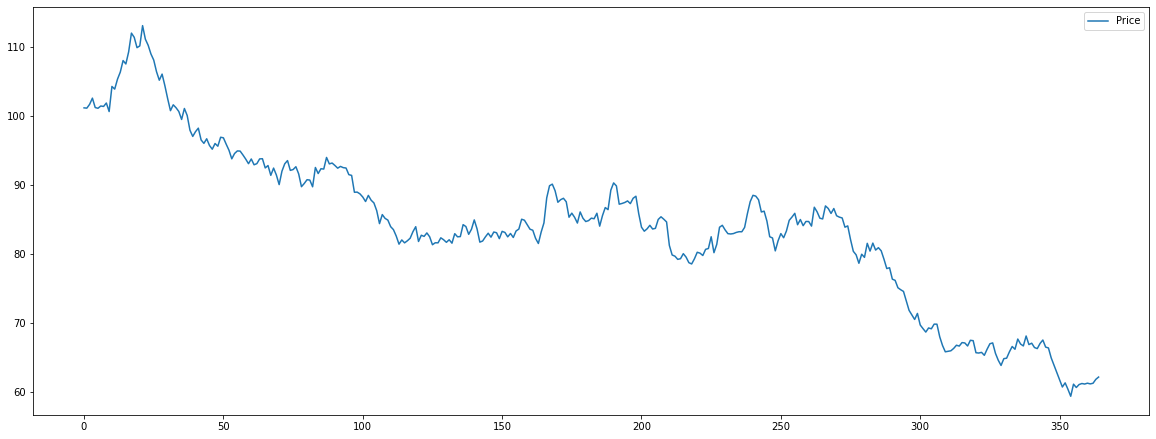

In [135]:
initial_price = 100
price_daily = pd.DataFrame(data={'Price':[]})
r = 0.12

for i in range(365):
    price_daily = price_daily.append({'Price':exp((r - 0.5 * 0.25**2) * 1/365 + 0.25 * sqrt(1/365) *random.gauss(0,1.0))}, ignore_index=True)

price_daily = (price_daily.cumprod()) * initial_price
price_daily.plot(figsize=(20,7.5));

#### Part C

**Approximately** the higher the values in the eighth column, the higher the values in the seventh column. In fact, the conclusion is that the greater the price difference between K1 and K2, the greater the difference between Gap Option and Standard Option price.

#### Part D

**Yes, it is reliable**. As you can see Option prices in fifth(GBM) and sixth column (BSM) are close to each other